In [1]:
# Import libraries to be used.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

In [2]:
# Define a random state value
RANDOM_STATE = 3030

In [3]:
# Define column names which will be used instead of the ones in the datasets.
column_names = [
    "age", "sex", "chest_pain_type", "rest_bp", "cholesterol",
    "fasting_bs", "resting_ecg", "max_hr", "exercise_angina", "st_exercise_depression",
    "st_exercise_slope", "major_vessels_fluorospy", "thal", "angiographic_disease"
]
na_values = ["?"] # Define what values will be interpreted as missing values, in this dataset the "?" character is used for this.

# Load all datasets using relative paths and combine into one dataframe.
df = pd.concat([
    pd.read_csv("../data/processed.cleveland.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.hungarian.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.switzerland.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.va.data", names=column_names, na_values=na_values)
]).drop(['st_exercise_slope', 'major_vessels_fluorospy', 'thal'], axis=1)

In [4]:
df[df["angiographic_disease"] > 1] = 1

In [5]:
df['age'].fillna((df['age'].mean()), inplace=True)
df['rest_bp'].fillna((df['rest_bp'].mean()), inplace=True)
df['cholesterol'].fillna((df['cholesterol'].mean()), inplace=True)
df['max_hr'].fillna((df['max_hr'].mean()), inplace=True)
df['st_exercise_depression'].fillna((df['st_exercise_depression'].mean()), inplace=True)
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [6]:
# Set category attributes
df["sex"] = df["sex"].astype("category")
df["chest_pain_type"] = df["chest_pain_type"].astype("category")
df["fasting_bs"] = df["fasting_bs"].astype("category")
df["resting_ecg"] = df["resting_ecg"].astype("category")
df["exercise_angina"] = df["exercise_angina"].astype("category")
df["angiographic_disease"] = df["angiographic_disease"].astype("category")

In [7]:
df["chest_pain_type"] = df["chest_pain_type"].map({1.0: "typical_angina", 2.0: "atypical_angina", 3.0: "non_angingal_pain", 4.0: "asymptomatic"})
df["resting_ecg"] = df["resting_ecg"].map({0.0: "resting_ecg_normal", 1.0: "resting_ecg_stt_abnormal", 2.0: "resting_ecg_left_ventricular_hypertrophy"})

ohe_chest_pain = pd.get_dummies(df["chest_pain_type"])
ohe_resting_ecg = pd.get_dummies(df["resting_ecg"])

df = pd.concat([df, ohe_chest_pain, ohe_resting_ecg], axis=1)
df.drop(["chest_pain_type"], axis=1, inplace=True)
df.drop(["resting_ecg"], axis=1, inplace=True)

In [8]:
df_X = df.drop(["angiographic_disease"], axis=1)

In [9]:
X = MinMaxScaler().fit_transform(df_X.to_numpy())
Y = df["angiographic_disease"].to_numpy()

In [10]:
def evaluate_model(estimator, params, estimator_name):
    print("******** STARTING TRAINING AND EVALUATION OF {} ********".format(estimator_name))
    evaluation_results = {}
    calculated_scores = []
    SCORERS = ["roc_auc", "f1_macro", "accuracy", 'recall', 'precision', 'jaccard']
    CV_K = 5

    for n_features in [3, 6, 9, 12, 15]:
        # Find the best k features
        select_k_best = SelectKBest(chi2, k=n_features).fit(X, Y)
        X_new = select_k_best.transform(X)

        # Perform grid search to find the best estimator for this feature set
        clf = GridSearchCV(estimator=estimator, param_grid=params, refit=False)
        clf.fit(X_new, Y)
        best_estimator = clone(estimator).set_params(**clf.best_params_)

        index_name = "{}_features".format(n_features)
        selected_features = select_k_best.get_feature_names_out(input_features=df_X.columns)
        evaluation_results[index_name] = {"scores": {}, "features": selected_features, "best_hyperparameters": clf.best_params_}

        print("Running {}-CV with features={}, estimator={}".format(CV_K, selected_features, best_estimator))

        # Perform cross-validation in order to evaluate the best parameter found by grid-search on the feature set.
        scores = cross_validate(estimator=best_estimator, X=X_new, y=Y, cv=CV_K, scoring=SCORERS)
        # Retrieve names of scores for visualization purposes.
        for key in scores.keys():
            if ("test_" in key):
                score_name = key.split("test_")[1]
                if (score_name not in calculated_scores):
                    calculated_scores.append(score_name)
                evaluation_results[index_name]["scores"][score_name] = scores[key]
    
    scores_to_plot = {}
    # Plot settings.
    plt.rcParams.update({'font.size': 13})
    plt.figure(figsize=(30,15))

    for i, score_name in enumerate(calculated_scores):
        scores_to_plot[score_name] = {}
        for feat_set in evaluation_results.keys():
            scores_to_plot[score_name][feat_set] = round(np.mean(evaluation_results[feat_set]["scores"][score_name]), 5)
        # Plot data.
        plt.subplot(2, 3, i+1)
        plt.bar(scores_to_plot[score_name].keys(), scores_to_plot[score_name].values())
        plt.title("{} over feature sets, {}".format(score_name, estimator_name))
        plt.grid()

    feature_set_keys = scores_to_plot[list(scores_to_plot.keys())[0]].keys()
    rows = []
    index_names = list(scores_to_plot.keys())
    index_names.append("best_hyperparameters")

    # Gather scores by metric.
    for score in scores_to_plot.keys():
        score_averages = []
        for feat_set in scores_to_plot[score].keys():
            score_averages.append(scores_to_plot[score][feat_set])
        rows.append(score_averages)

    # Supplement rows with the best hyperparameters by feature set.
    best_hyperparameters = []
    for feat_set in evaluation_results.keys():
        best_hyperparameters.append(evaluation_results[feat_set]["best_hyperparameters"])
    rows.append(best_hyperparameters)

    measurement_result = pd.DataFrame(data=rows, columns=evaluation_results.keys(), index=index_names)
    measurement_result.to_csv("../model_measurement_results/{}_evaluation_results.csv".format(estimator_name))
    return measurement_result

******** STARTING TRAINING AND EVALUATION OF SVM ********
Running 5-CV with features=['exercise_angina' 'typical_angina' 'atypical_angina'], estimator=SVC(C=5, kernel='sigmoid', random_state=3030)
Running 5-CV with features=['fasting_bs' 'exercise_angina' 'typical_angina' 'atypical_angina'
 'non_angingal_pain' 'resting_ecg_stt_abnormal'], estimator=SVC(C=1, kernel='poly', random_state=3030)
Running 5-CV with features=['rest_bp' 'fasting_bs' 'max_hr' 'exercise_angina' 'typical_angina'
 'atypical_angina' 'non_angingal_pain' 'resting_ecg_normal'
 'resting_ecg_stt_abnormal'], estimator=SVC(C=10, kernel='linear', random_state=3030)
Running 5-CV with features=['age' 'sex' 'rest_bp' 'cholesterol' 'fasting_bs' 'max_hr'
 'exercise_angina' 'typical_angina' 'atypical_angina' 'non_angingal_pain'
 'resting_ecg_normal' 'resting_ecg_stt_abnormal'], estimator=SVC(C=1, random_state=3030)
Running 5-CV with features=['age' 'sex' 'rest_bp' 'cholesterol' 'fasting_bs' 'max_hr'
 'exercise_angina' 'st_exercis

,3_features,6_features,9_features,12_features,15_features
roc_auc,0.87121,0.83591,0.87566,0.86525,0.8658
f1_macro,0.80834,0.81099,0.80727,0.77991,0.79139
accuracy,0.81087,0.81413,0.81196,0.78913,0.79783
recall,0.78589,0.76822,0.85857,0.80351,0.80351
precision,0.87008,0.89672,0.81559,0.83395,0.84203
jaccard,0.69913,0.69666,0.71791,0.68031,0.68799
best_hyperparameters,"{'C': 5, 'kernel': 'sigmoid'}","{'C': 1, 'kernel': 'poly'}","{'C': 10, 'kernel': 'linear'}","{'C': 1, 'kernel': 'rbf'}","{'C': 1, 'kernel': 'rbf'}"


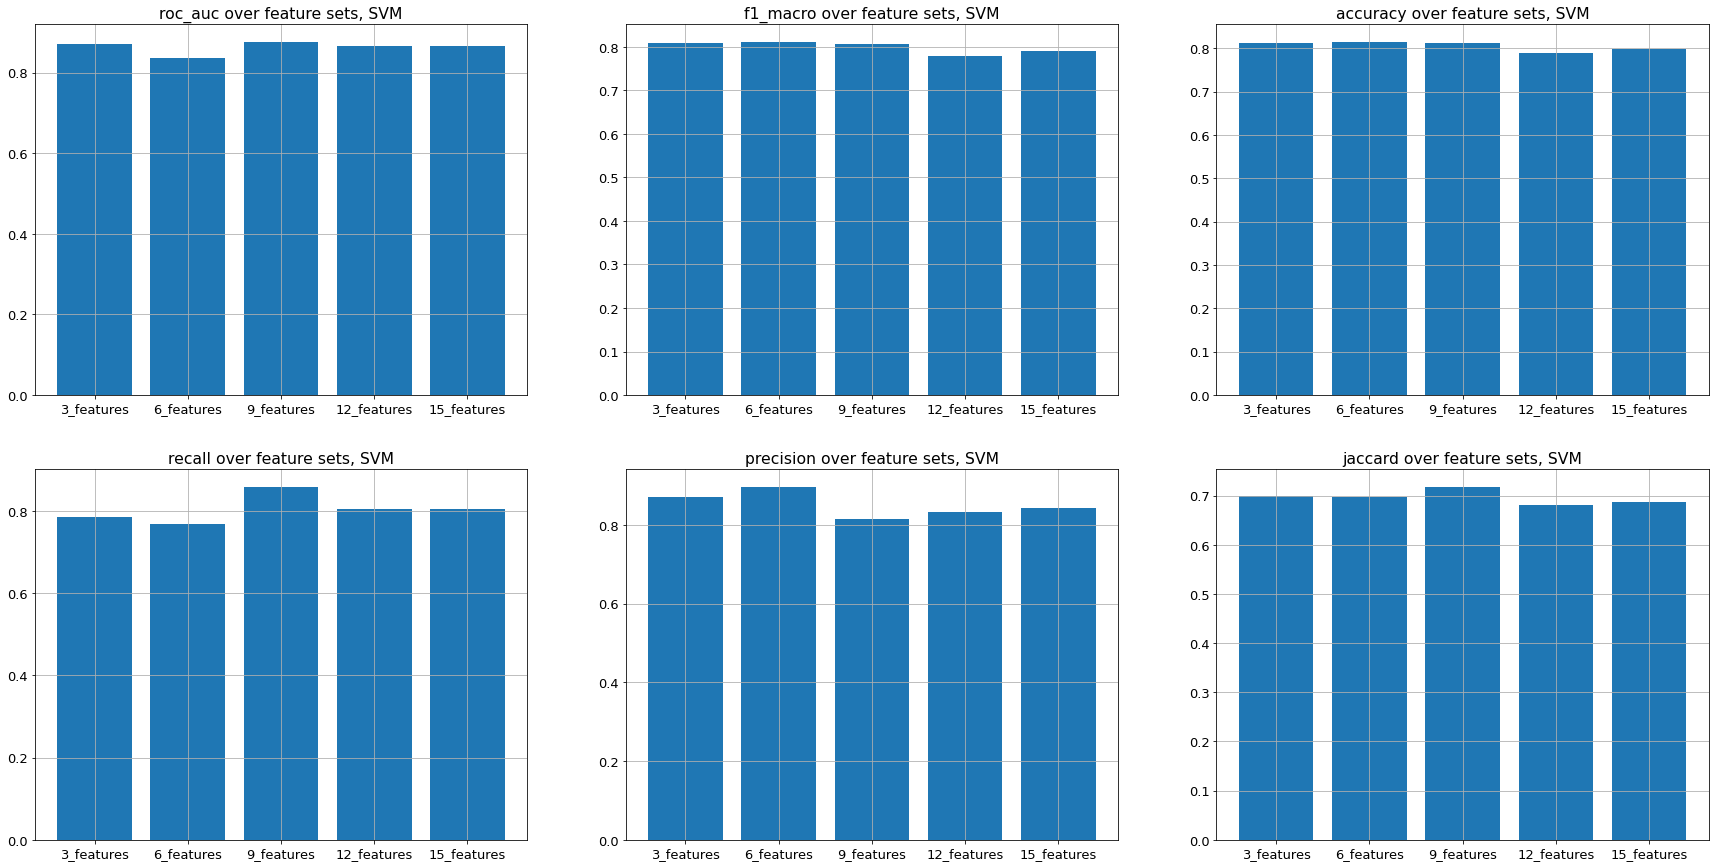

In [11]:
evaluate_model(estimator=SVC(random_state=RANDOM_STATE), params={'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[1, 5, 10]}, estimator_name="SVM")

******** STARTING TRAINING AND EVALUATION OF KNN ********
Running 5-CV with features=['exercise_angina' 'typical_angina' 'atypical_angina'], estimator=KNeighborsClassifier(algorithm='ball_tree', n_neighbors=101, p=1)
Running 5-CV with features=['fasting_bs' 'exercise_angina' 'typical_angina' 'atypical_angina'
 'non_angingal_pain' 'resting_ecg_stt_abnormal'], estimator=KNeighborsClassifier(algorithm='ball_tree', n_neighbors=101, p=1)
Running 5-CV with features=['rest_bp' 'fasting_bs' 'max_hr' 'exercise_angina' 'typical_angina'
 'atypical_angina' 'non_angingal_pain' 'resting_ecg_normal'
 'resting_ecg_stt_abnormal'], estimator=KNeighborsClassifier(algorithm='brute', n_neighbors=11)
Running 5-CV with features=['age' 'sex' 'rest_bp' 'cholesterol' 'fasting_bs' 'max_hr'
 'exercise_angina' 'typical_angina' 'atypical_angina' 'non_angingal_pain'
 'resting_ecg_normal' 'resting_ecg_stt_abnormal'], estimator=KNeighborsClassifier(algorithm='ball_tree', n_neighbors=101)
Running 5-CV with features=['a

,3_features,6_features,9_features,12_features,15_features
roc_auc,0.87567,0.90767,0.88961,0.91468,0.91404
f1_macro,0.80142,0.81871,0.8096,0.79775,0.81607
accuracy,0.80543,0.82065,0.81413,0.80543,0.82065
recall,0.78,0.78393,0.81532,0.81138,0.85059
precision,0.87285,0.88614,0.85841,0.85343,0.83708
jaccard,0.69183,0.70846,0.71227,0.70091,0.72534
best_hyperparameters,"{'algorithm': 'ball_tree', 'n_neighbors': 101,...","{'algorithm': 'ball_tree', 'n_neighbors': 101,...","{'algorithm': 'brute', 'n_neighbors': 11, 'p': 2}","{'algorithm': 'ball_tree', 'n_neighbors': 101,...","{'algorithm': 'ball_tree', 'n_neighbors': 101,..."


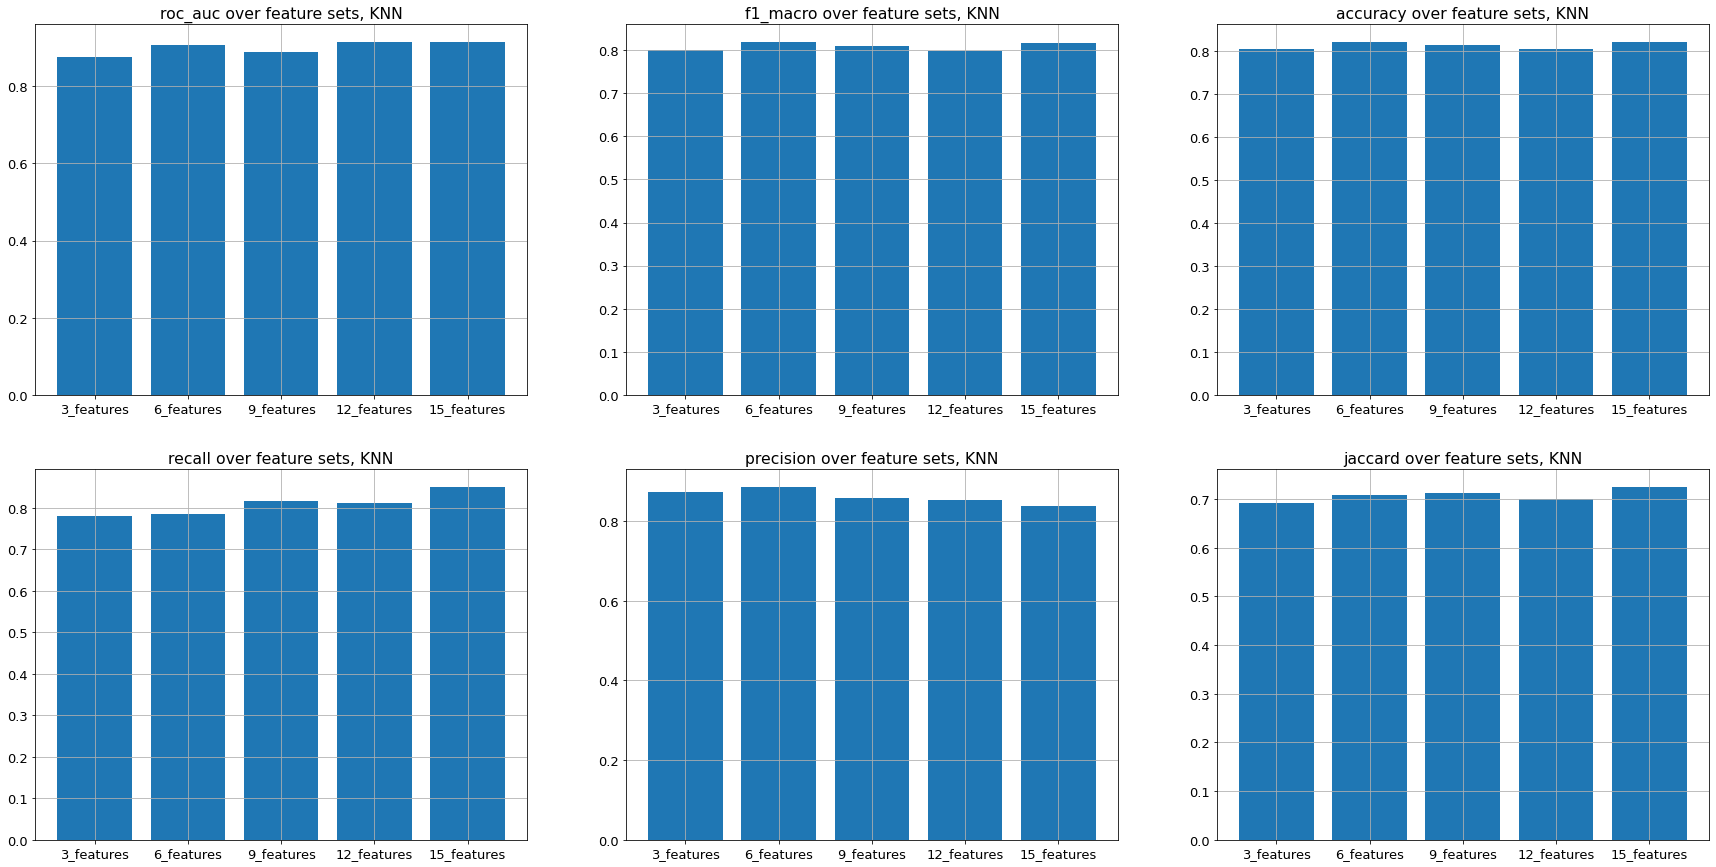

In [12]:
evaluate_model(estimator=KNeighborsClassifier(), params={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 27, 51, 101], 'algorithm': ('ball_tree', 'kd_tree', 'brute'), 'p': [1, 2]}, estimator_name="KNN")

******** STARTING TRAINING AND EVALUATION OF RF ********
Running 5-CV with features=['exercise_angina' 'typical_angina' 'atypical_angina'], estimator=RandomForestClassifier(n_estimators=1, random_state=3030)
Running 5-CV with features=['fasting_bs' 'exercise_angina' 'typical_angina' 'atypical_angina'
 'non_angingal_pain' 'resting_ecg_stt_abnormal'], estimator=RandomForestClassifier(n_estimators=5, random_state=3030)
Running 5-CV with features=['rest_bp' 'fasting_bs' 'max_hr' 'exercise_angina' 'typical_angina'
 'atypical_angina' 'non_angingal_pain' 'resting_ecg_normal'
 'resting_ecg_stt_abnormal'], estimator=RandomForestClassifier(criterion='entropy', n_estimators=47, random_state=3030)
Running 5-CV with features=['age' 'sex' 'rest_bp' 'cholesterol' 'fasting_bs' 'max_hr'
 'exercise_angina' 'typical_angina' 'atypical_angina' 'non_angingal_pain'
 'resting_ecg_normal' 'resting_ecg_stt_abnormal'], estimator=RandomForestClassifier(criterion='entropy', n_estimators=47, random_state=3030)
Runn

,3_features,6_features,9_features,12_features,15_features
roc_auc,0.87554,0.88933,0.87458,0.87068,0.88724
f1_macro,0.80718,0.81561,0.78356,0.76282,0.77453
accuracy,0.80978,0.81848,0.78913,0.775,0.78478
recall,0.77608,0.77606,0.79357,0.78381,0.78773
precision,0.87887,0.89613,0.83291,0.83274,0.84232
jaccard,0.69466,0.70401,0.67942,0.6621,0.67341
best_hyperparameters,"{'criterion': 'gini', 'n_estimators': 1}","{'criterion': 'gini', 'n_estimators': 5}","{'criterion': 'entropy', 'n_estimators': 47}","{'criterion': 'entropy', 'n_estimators': 47}","{'criterion': 'entropy', 'n_estimators': 23}"


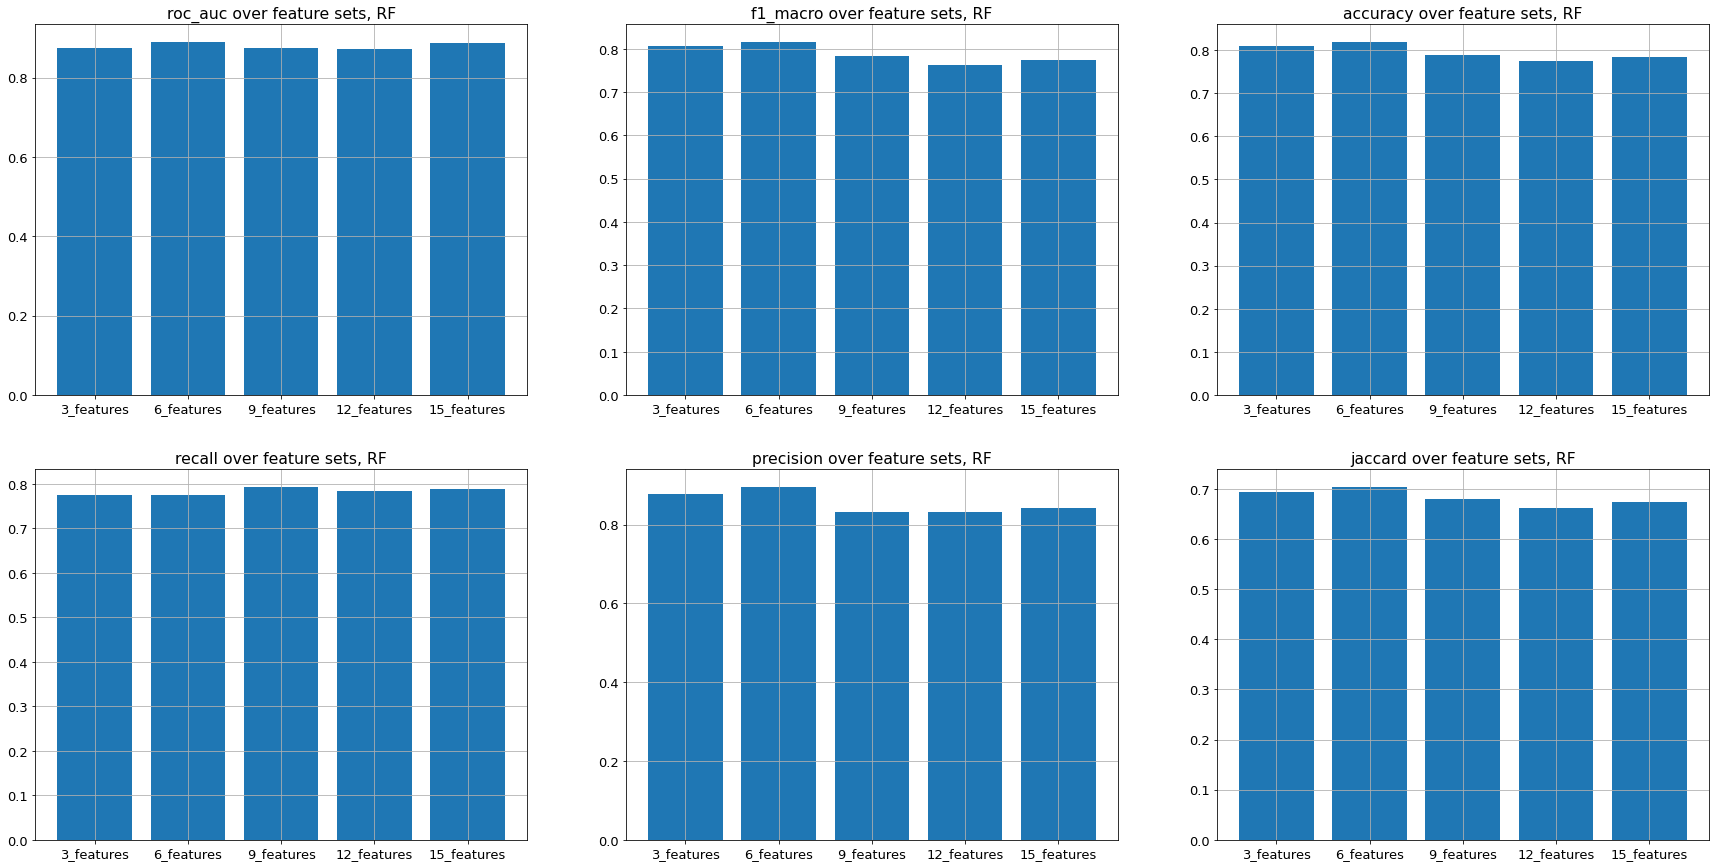

In [13]:
evaluate_model(estimator=RandomForestClassifier(random_state=RANDOM_STATE), params={'n_estimators': [1, 5, 11, 23, 47, 99], 'criterion': ('gini', 'entropy')}, estimator_name="RF")